# 1: Skip-gram Model for Word2Vec**

<br>

**26th and 27th January**

There are two Word2Vec architectures for creating word embeddings: the Continuous Bag of Words (CBOW) architecture and the Skip Gram architecture . In this project, we will obtain our own word embeddings by training a skip-gram neural network model. 


The skip gram model is essentially a feedforward neural network with one hidden layer, trained to predict the context word given a target word. There are two ways to train this model: 

(1) using a hierarchical softmax function and/or 

(2) by negative sampling. In this project, we will be training using
negative sampling. To train with negative sampling, the model is cast as a binary classification problem. The dataset would consist of positive and negative examples of the form:

Input | label
--| --
(target_word, word_in_its_context)       |  1 
(target_word, word_not_in_its_context)   |  0

created from the sentences in a corpus. The exact number of positive and negative examples will depend on the window size, and the balance ratio of positive:negative examples.  

As an example, consider the sentence: “ **The quick brown
fox jumped over the lazy dog** ”. For the target word ' **fox** ' and a window size of 2, all the positive and negative examples drawn from this sentence would be:

Input | label
--| --
(fox, the) | 0
(fox, quick) | 1
(fox, brown) | 1
(fox, jumped) | 1
(fox, over) |1
(fox, lazy) | 0
(fox, dog) | 0

The model is trained to learn to predict 1 when a word is in the context of the target word (i.e.in the window of the target word) and 0 otherwise. The model thus learns the statistics of the given corpus: the frequency with two words appear together would determine how similar they are (similarity is usually measured using cosine distance). After training, the trained hidden layer weights are the word embeddings.



### **1. Downloading the Corpus**

Our training data will be comprised of 3 documents from the Gutenberg corpus. We can find this and other corpora in nltk https://www.nltk.org/book/ch02.html

In [19]:
import nltk

nltk.download('punkt')
nltk.download('gutenberg')
from nltk.corpus import gutenberg
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')

[nltk_data] Downloading package punkt to /Users/jiahao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/jiahao/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [20]:
print(len(austen))

16463


In [21]:
austen[0]

['[', 'Sense', 'and', 'Sensibility', 'by', 'Jane', 'Austen', '1811', ']']

### **2. Preprocessing the Training Corpus**

In this section, we will write code to remove special characters, empty strings, digits and
stopwords from the sentences and put all the words into lower cases. We might also consider removing sentences with fewer than 3 words or at least empty sentences.

In [22]:
from nltk.corpus import stopwords
def remove_stopwords(text):
    
    for word in text:
        if word in stopwords.words('english'):
            text.remove(word)
    return text

def keep_char (text):
    
    for word in text:
        if not word.isalpha():
            text.remove(word)
    
    return text

In [23]:
def preprocess_corpus (corpus):
    temp = []
    #remove special characters and digits 
    tokens = [keep_char(x) for x in corpus]
    
    #remove stopwords
    tokens = [remove_stopwords(x) for x in tokens]
        
    #remove special characters and digits 
    tokens = [keep_char(x) for x in tokens]
    
    for i in tokens:
        #put all the words into lower cases.
        token = [x.lower() for x in i]
        if len(token) > 3:
            temp.append(token)
    
    return temp

In [24]:
normalized_corpus = preprocess_corpus(austen)
print('The new length of the preprocessed output is', len(normalized_corpus))

The new length of the preprocessed output is 14528


In [25]:
sample = austen[:2] + austen[100:102]
preprocessed_sample = preprocess_corpus(sample)


print(len(sample), sample)
print()
print(len(preprocessed_sample), preprocessed_sample)

4 [['Sense', 'Sensibility', 'Jane', 'Austen'], ['CHAPTER'], ['But', 'if', 'Mrs', 'Dashwood', 'live', 'fifteen', 'years', 'shall', 'completely', 'taken'], ['Fifteen', 'years']]

2 [['sense', 'sensibility', 'jane', 'austen'], ['but', 'if', 'mrs', 'dashwood', 'live', 'fifteen', 'years', 'shall', 'completely', 'taken']]


### **3. Creating the Corpus Vocabulary and Preparing the Data**


To prepare the data for machine learning, we will write code to prepare 3 variables:

1. \<word2idx>: a lookup table, a dictionary of (word index: word) pairs where **word index** is a unique integer assigned to every **unique word** in the corpus.
2. \<idx2word>: a dictionary of (token: token index), a reversal of \<word2idx>. 
3. \<sents_as_ids>: The input to the model cannot be text, rather, each word needs to be represented by a unique integer and each sentence an array of integers.


The incomplete code provided below is just a guide. 

In [8]:
def prepareData(normalized_corpus):
    temp = []
    ans = {}
    for i in normalized_corpus:
        for j in i:
            if j not in temp:
                temp.append(j)
    for index,token in enumerate(temp):
        ans[token] = index

    return ans


def prepareSentsAsId(normalized_corpus):
    ans = []
    
    for i in normalized_corpus:
        temp = []
        for j in i:
            temp.append(word2idx[j])
        ans.append(temp)
    return ans


word2idx = prepareData(normalized_corpus)
idx2word = {i: j for j, i in word2idx.items()}

In [9]:
print('Number of unique words:', len(word2idx))
print('\nSample word2idx: ', list(word2idx.items())[:10])
print('\nSample idx2word:', list(idx2word.items())[:10])
print('\nSample sents_as_id:', prepareSentsAsId(preprocessed_sample))

Number of unique words: 10241

Sample word2idx:  [('sense', 0), ('sensibility', 1), ('jane', 2), ('austen', 3), ('the', 4), ('family', 5), ('dashwood', 6), ('long', 7), ('settled', 8), ('sussex', 9)]

Sample idx2word: [(0, 'sense'), (1, 'sensibility'), (2, 'jane'), (3, 'austen'), (4, 'the'), (5, 'family'), (6, 'dashwood'), (7, 'long'), (8, 'settled'), (9, 'sussex')]

Sample sents_as_id: [[0, 1, 2, 3], [50, 620, 85, 6, 237, 673, 43, 674, 337, 675]]


After we have created the three variables, set the <vocab_size> and <embed_size> variables with the following commands:

In [10]:
VOCAB_SIZE = len(word2idx) 
EMBED_SIZE = 100 # We are creating 100D embeddings.

In [11]:
print('Number of unique words:', len(word2idx))

Number of unique words: 10241


### **4. Generating training instances**


In this section we would generate the training examples of the format shown in introduction using the keras skip-gram generator https://keras.io/preprocessing/sequence/ 

In [12]:
from keras.preprocessing.sequence import skipgrams

skip_grams = []
for i in prepareSentsAsId(normalized_corpus):
    skip_grams.append(skipgrams(i, vocabulary_size = (len(word2idx)+1),
                                shuffle=False, window_size=4))

In [13]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]

for i in range(len(pairs)):
    print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
    # the first word and its index
    idx2word[pairs[i][0]], pairs[i][0],
    # the second word and its index
    idx2word[pairs[i][1]], pairs[i][1],
    # the label
    labels[i]))

(sensibility (1), jane (2)) -> 1
(sensibility (1), austen (3)) -> 1
(jane (2), sensibility (1)) -> 1
(jane (2), austen (3)) -> 1
(austen (3), sensibility (1)) -> 1
(austen (3), jane (2)) -> 1
(austen (3), lasting (1565)) -> 0
(sensibility (1), chapter (6835)) -> 0
(austen (3), politest (6792)) -> 0
(jane (2), cramer (7879)) -> 0
(sensibility (1), transient (9379)) -> 0
(jane (2), wore (2591)) -> 0


### **5. Building the Skip-gram Neural Network Architecture**

In this section we would be building the skip-gram neural network architecture using the Keras Functional API and the Sequential model introduced in the previous lab. https://keras.io/getting-started/functional-api-guide/ 

In [14]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils.vis_utils import plot_model

The skip-gram model is two input one output feedforward neural network with one hidden layer and this will be built over a series of steps.

#### **A. The first step is to initialize and transform the first input using the following lines of code:**

In [15]:
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
target_word = Input((1,), dtype='int32')


# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer 
# from whose weights we will get the word embeddings.
target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                             embeddings_initializer='glorot_uniform',
                             input_length=1)(target_word)


# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened 
# or reshaped into a (num_inputs x embed_size) tensor.
target_input = Reshape((EMBED_SIZE, ))(target_embedding)

Metal device set to: Apple M1 Pro


2022-03-02 15:23:41.952174: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-02 15:23:41.952364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### **B. Write similar code for the ‘context_word’ input.**

In [16]:
context_word = Input((1,), dtype='int32')

context_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='context_embed_layer',
                             embeddings_initializer='glorot_uniform',
                             input_length=1)(context_word)

context_input = Reshape((EMBED_SIZE, ))(context_embedding)

#### **C. Merge the inputs.**

Recall, each training instance is a (target_word, context_word) combination. Since we are trying to learn the degree of closeness between the two words, the model will compute the cosine distance between the two inputs using the <Dot> layer. https://keras.io/layers/merge/, hence fusing the two inputs into one.


In [17]:
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

#### **D. The Output Layer**

Pass the merged inputs (now a vector with a single number the cosine distance between the two input vectors for each word) into a sigmoid activated neuron. The output of this layer is the output of the model.

In [18]:
label = Dense(1, activation = 'sigmoid')(merged_inputs)

#### **E. Initialize the model:**

In [19]:
# label is the output of step D.
model = Model(inputs=[target_word, context_word], outputs = [label]) 

#### **F. Compile the model using the <model.compile> command.** Use Loss = ‘mean_squared_error’, optimizer = ‘rmsprop’.

In [20]:
model.compile(optimizer='rmsprop',
              loss='mean_squared_error')

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 target_embed_layer (Embedding)  (None, 1, 100)      1024100     ['input_1[0][0]']                
                                                                                                  
 context_embed_layer (Embedding  (None, 1, 100)      1024100     ['input_2[0][0]']                
 )                                                                                            

#### **G. Plot the model using ```vis utils```.**

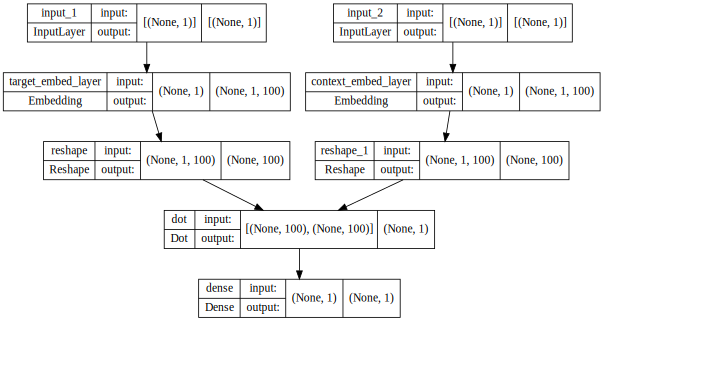

In [22]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, 
                           show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

### **6.Training the Model**

Run the following block of code to train the model for 5 epochs:

In [23]:
import numpy as np

NUM_EPOCHS = 5

for epoch in range(1, NUM_EPOCHS+1):
    epoch_loss = 0
    for i, sent_examples in enumerate(skip_grams):
        target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
        context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
        labels = np.array(sent_examples[1], dtype='int32')
        X = [target_wds, context_wds]
        Y = labels

        if i % 5000 == 0: 
            print('Processed %d sentences' %i)
        
        epoch_loss += model.train_on_batch(X, Y)
    print('Processed all %d sentences' %i)
    print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')



Processed 0 sentences


2022-03-02 15:27:14.417234: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-02 15:27:14.417880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-02 15:27:14.682966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-02 15:27:14.889799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Processed 5000 sentences
Processed 10000 sentences
Processed all 14527 sentences
Epoch: 1 Loss: 2088.5987780881114 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 14527 sentences
Epoch: 2 Loss: 1715.897818570491 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 14527 sentences
Epoch: 3 Loss: 1656.1730864048004 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 14527 sentences
Epoch: 4 Loss: 1634.6372010190971 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 14527 sentences
Epoch: 5 Loss: 1622.4500486205798 



### **7. Getting the Word Embeddings**

The word embeddings are the weights of the target word embedding layer.


In [24]:
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0] 

# should return (VOCAB_SIZE, EMBED_SIZE)
print(word_embeddings.shape)

(10241, 100)


Print out a few words and their embeddings using the next block of code. Our output may not be exactly as above but the command should print 10 words and their respective vectors.

In [25]:
from pandas import DataFrame

print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

                   0         1         2         3         4         5   \
sense       -0.013191  0.010492  0.013087  0.017900  0.004934 -0.014447   
sensibility -0.046498 -0.014590 -0.000525 -0.009585 -0.024555 -0.031843   
jane        -0.007119  0.003256 -0.053789 -0.026471 -0.025794  0.023009   
austen      -0.016459  0.013805 -0.008099 -0.003911 -0.017598  0.007957   
the         -0.010649 -0.016116 -0.003619  0.077740 -0.080641  0.011983   
family      -0.005288  0.058220  0.039026 -0.016200  0.010911 -0.039246   
dashwood    -0.023614 -0.090782 -0.095932  0.005459 -0.026532 -0.055629   
long        -0.029477 -0.027634 -0.053599 -0.026846 -0.094589 -0.059164   
settled     -0.086880  0.011689 -0.012119  0.035283 -0.025754 -0.028589   
sussex      -0.032597 -0.014307  0.016387 -0.018499 -0.028822 -0.029536   

                   6         7         8         9   ...        90        91  \
sense        0.010480  0.005788 -0.018801 -0.013037  ... -0.019915 -0.016813   
sensibility -0

### **8.  Measuring Similarity Between Word Pairs**



In [26]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(word_embeddings)

# should print(VOCAB_SIZE, VOCAB_SIZE)
print(similarity_matrix.shape)   

(10241, 10241)


### **9. Exploring and Visualizing the Word Embeddings using t-SNE**

**A.	Get the most similar words to the search items in the list below**

search_terms = ['family', 'love', 'equality', 'wisdom', 'justice',  'humour', 'rejection']

In [27]:
similarity_df = DataFrame(similarity_matrix, 
                          index=idx2word.values(), 
                          columns = idx2word.values())

In [28]:
similarity_df.head()

,sense,sensibility,jane,austen,the,family,dashwood,long,settled,sussex,...,wheedled,caressed,resort,transgressions,kinds,depriving,requited,supplies,accessions,national
sense,1.000000,0.050751,0.151152,0.155992,0.044704,-0.038682,-0.162070,-0.121895,0.117885,0.148553,...,0.125872,-0.095832,0.167213,0.060350,0.014763,0.058387,0.257383,0.125794,-0.012572,-0.074961
sensibility,0.050751,1.000000,0.205028,0.045446,0.015701,0.166559,0.191675,0.009978,0.085376,0.266738,...,-0.020826,-0.147694,0.037703,-0.097502,0.052908,-0.083064,-0.054812,0.040888,-0.019956,0.003715
jane,0.151152,0.205028,1.000000,-0.008402,0.219007,0.329271,0.122300,0.370298,0.205676,0.008668,...,-0.027874,-0.048457,-0.101146,0.031714,-0.033291,-0.160834,-0.092177,0.113669,-0.073134,-0.045928
austen,0.155992,0.045446,-0.008402,1.000000,-0.033376,0.092375,-0.105947,-0.076544,0.160687,0.046298,...,0.111761,0.037394,0.205320,0.140371,0.157410,0.260792,0.167196,0.120317,-0.034423,0.108798
the,0.044704,0.015701,0.219007,-0.033376,1.000000,0.474494,0.007785,0.264014,0.412211,-0.110241,...,-0.004790,-0.096258,-0.078681,0.017996,0.036117,-0.232757,0.062627,-0.019443,-0.043867,-0.104749


In [29]:
search_terms = ['think', 'thought', 'mr', 'friend', 'love', 'disdain']

# write code to get the 5 words most similar to the words in search_terms
similar_words ={}

for i in search_terms:
    similar_words[i] = similarity_df[i].abs().sort_values(
                        ascending = False).iloc[1:6].index.to_list()

print(similar_words)

{'think': ['dear', 'does', 'hardly', 'know', 'not'], 'thought': ['none', 'given', 'croft', 'yesterday', 'whom'], 'mr': ['martin', 'elton', 'robert', 'weston', 'woodhouse'], 'friend': ['fairfax', 'musgrove', 'long', 'father', 'walter'], 'love': ['influence', 'truth', 'considered', 'when', 'either'], 'disdain': ['fluently', 'easter', 'amiably', 'draught', 'minehead']}


**B. Plot the words in the dictionary above using t-SN**E 

https://lvdmaaten.github.io/tsne/ 

Plot 50 of the word embeddings using the code snippets below:














/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


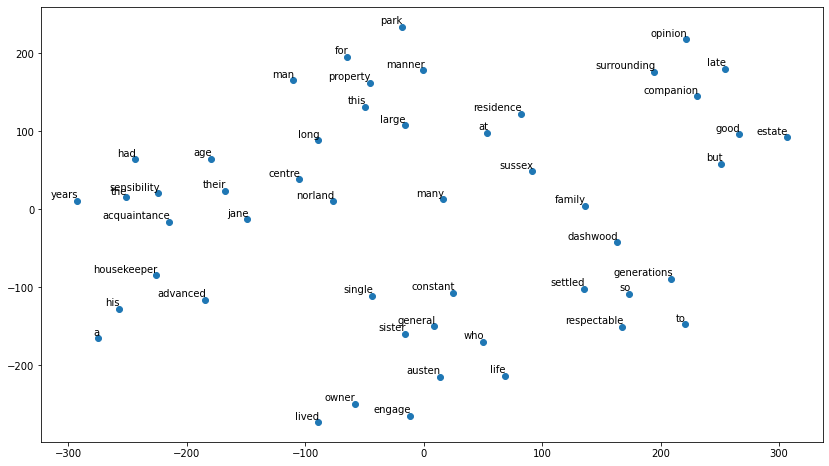

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50 

T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')                      	                        



**10. Resources used**

http://jalammar.github.io/illustrated-word2vec/
https://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/ 
https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa 
https://adventuresinmachinelearning.com/word2vec-keras-tutorial/ 
https://www.tensorflow.org/tutorials/representation/word2vec#the_skip-gram_model 
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/word2vec/word2vec_basic.py 

